In [ ]:
pip install pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Analysis - Visualizations") \
    .getOrCreate()

spark

In [ ]:
import os
# Load cleaned data
df = spark.read.parquet("/Your-path/data/cleanedData")
# Show sample data to verify loading
df.show(5)
df.printSchema()

['_SUCCESS', '.part-00006-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00005-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00008-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00003-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '._SUCCESS.crc', '.part-00007-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00004-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00002-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00000-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', '.part-00001-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet.crc', 'part-00006-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet', 'part-00003-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet', 'part-00002-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet', 'part-00005-fde1b9ee-d448-4a3f-bbd6-7aff4e42f554-c000.snappy.parquet', 'p

+----+----------+
|hour|trip_count|
+----+----------+
|   0|    881593|
|   1|    570652|
|   2|    369685|
|   3|    236548|
|   4|    153200|
|   5|    182640|
|   6|    425141|
|   7|    845012|
|   8|   1165871|
|   9|   1341416|
|  10|   1477151|
|  11|   1597597|
|  12|   1727535|
|  13|   1797007|
|  14|   1938022|
|  15|   2002228|
|  16|   2035802|
|  17|   2192299|
|  18|   2278377|
|  19|   2024090|
+----+----------+
only showing top 20 rows



<ipython-input-10-4262798463>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hour", y="trip_count", data=trips_per_hour_pd, palette="Blues_d")


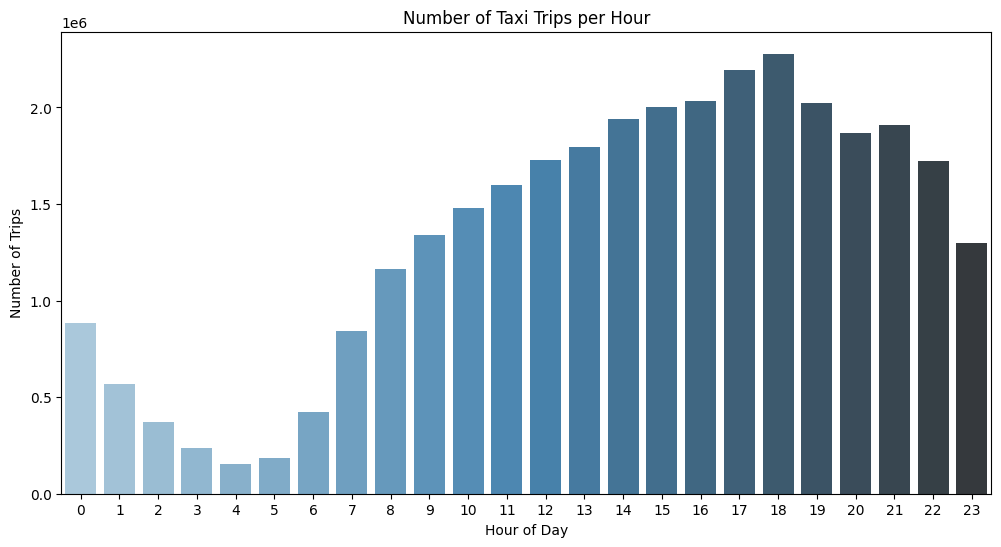

In [ ]:
from pyspark.sql.functions import hour, count
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from pickup datetime and count trips per hour
trips_per_hour = df.withColumn("hour", hour("tpep_pickup_datetime")) \
                   .groupBy("hour") \
                   .agg(count("*").alias("trip_count")) \
                   .orderBy("hour")

trips_per_hour.show()
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas dataframe for plotting
trips_per_hour_pd = trips_per_hour.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="hour", y="trip_count", data=trips_per_hour_pd, palette="Blues_d")
plt.title("Number of Taxi Trips per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()


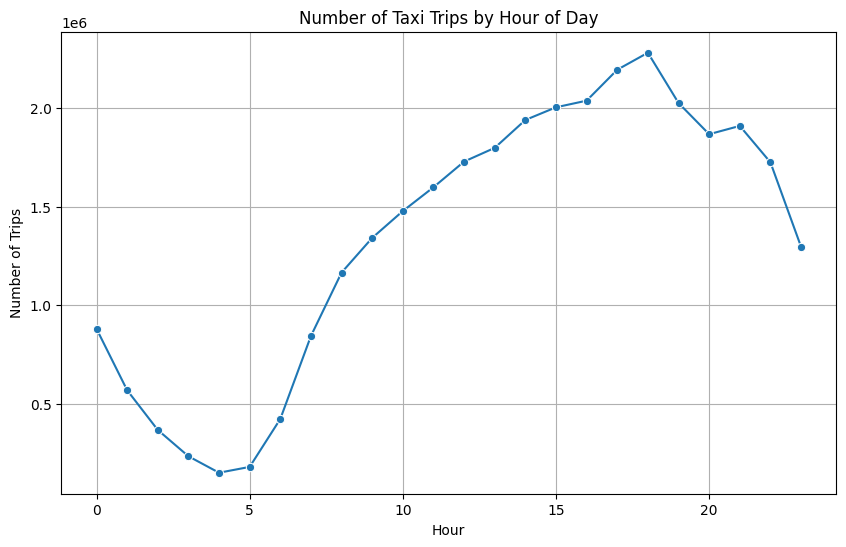

In [ ]:
df_hour = df.withColumn("hour", hour("tpep_pickup_datetime")) \
            .groupBy("hour").count() \
            .orderBy("hour")

df_hour_pd = df_hour.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_hour_pd, x="hour", y="count", marker='o')
plt.title("Number of Taxi Trips by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.show()


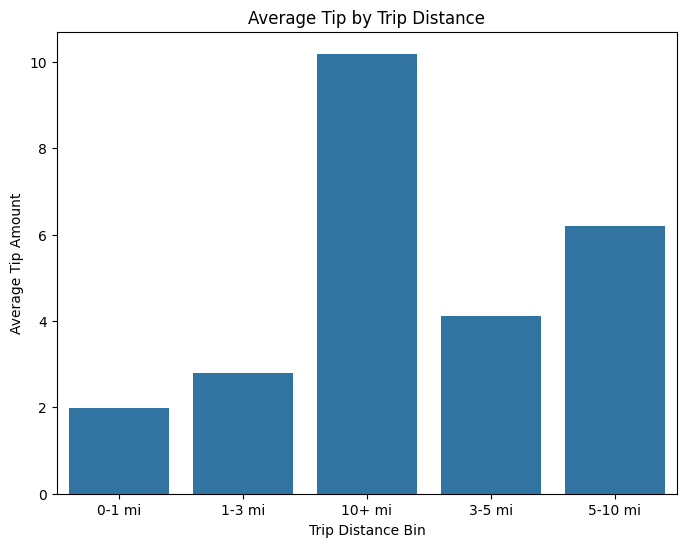

In [ ]:
from pyspark.sql.functions import when, col

df = df.withColumn("distance_bin", when(col("trip_distance") <= 1, "0-1 mi")
                   .when(col("trip_distance") <= 3, "1-3 mi")
                   .when(col("trip_distance") <= 5, "3-5 mi")
                   .when(col("trip_distance") <= 10, "5-10 mi")
                   .otherwise("10+ mi"))

tip_df = df.groupBy("distance_bin").agg({"tip_amount": "avg"}).withColumnRenamed("avg(tip_amount)", "avg_tip")
tip_pd = tip_df.toPandas().sort_values("distance_bin")

plt.figure(figsize=(8, 6))
sns.barplot(x="distance_bin", y="avg_tip", data=tip_pd)
plt.title("Average Tip by Trip Distance")
plt.xlabel("Trip Distance Bin")
plt.ylabel("Average Tip Amount")
plt.show()


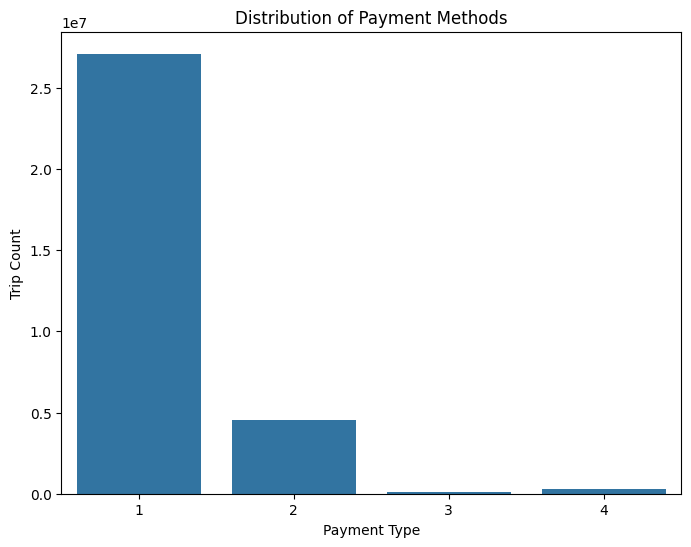

In [ ]:
df_payment = df.groupBy("payment_type").count().orderBy("count", ascending=False)
df_payment_pd = df_payment.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=df_payment_pd, x="payment_type", y="count")
plt.title("Distribution of Payment Methods")
plt.xlabel("Payment Type")
plt.ylabel("Trip Count")
plt.show()


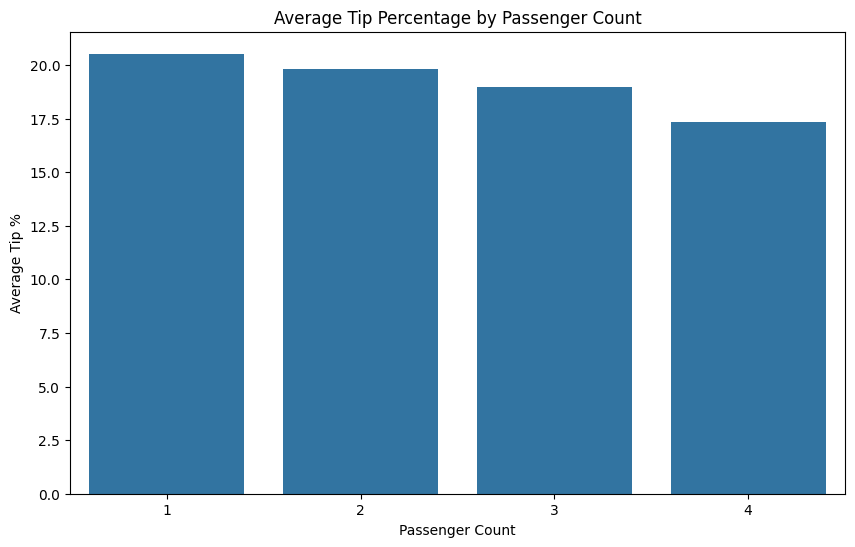

In [ ]:
from pyspark.sql.functions import col, when

# Avoid dividing by 0 or missing values
df_tip = df.withColumn("tip_percentage",
                       when(col("fare_amount") > 0, col("tip_amount") / col("fare_amount") * 100).otherwise(0)) \
           .groupBy("passenger_count") \
           .agg(avg("tip_percentage").alias("avg_tip_percentage")) \
           .orderBy("passenger_count")

df_tip_pd = df_tip.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_tip_pd, x="passenger_count", y="avg_tip_percentage")
plt.title("Average Tip Percentage by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Tip %")
plt.show()


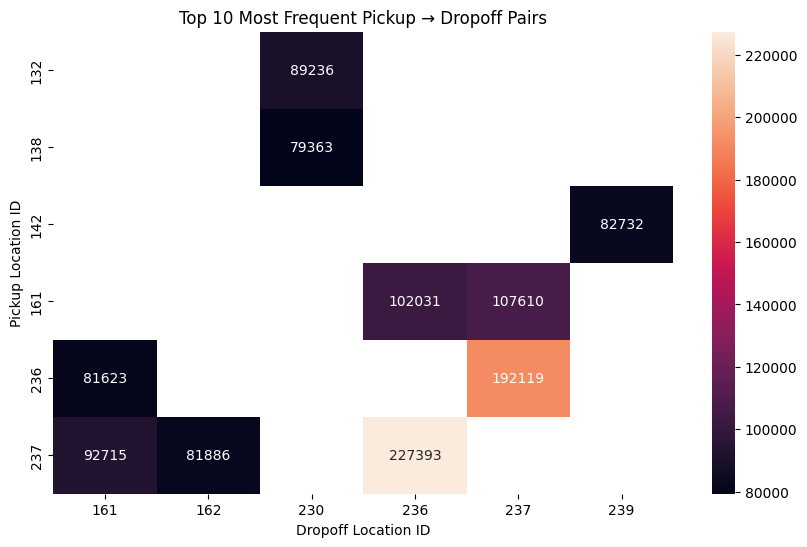

In [ ]:
df_locations = df.groupBy("PULocationID", "DOLocationID").count().orderBy("count", ascending=False).limit(10)
df_locations_pd = df_locations.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(df_locations_pd.pivot(index="PULocationID", columns="DOLocationID", values="count"), annot=True, fmt="g")
plt.title("Top 10 Most Frequent Pickup - Dropoff Pairs")
plt.xlabel("Dropoff Location ID")
plt.ylabel("Pickup Location ID")
plt.show()


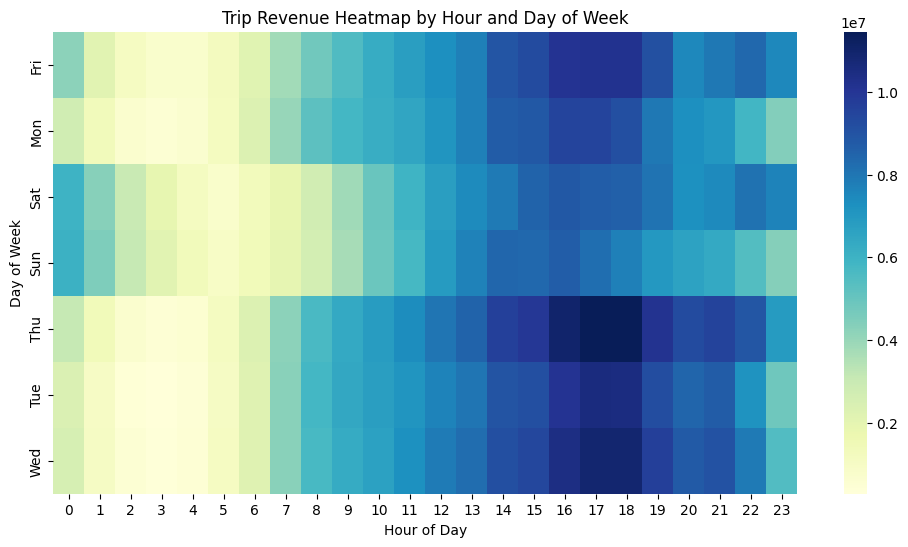

In [ ]:
from pyspark.sql.functions import hour, date_format, sum

df = df.withColumn("hour", hour("tpep_pickup_datetime"))
df = df.withColumn("day_of_week", date_format("tpep_pickup_datetime", "E"))

revenue_df = df.groupBy("day_of_week", "hour").agg(sum("total_amount").alias("total_revenue"))
revenue_pd = revenue_df.toPandas().pivot(index="day_of_week", columns="hour", values="total_revenue")

plt.figure(figsize=(12, 6))
sns.heatmap(revenue_pd, annot=False, cmap="YlGnBu")
plt.title("Trip Revenue Heatmap by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


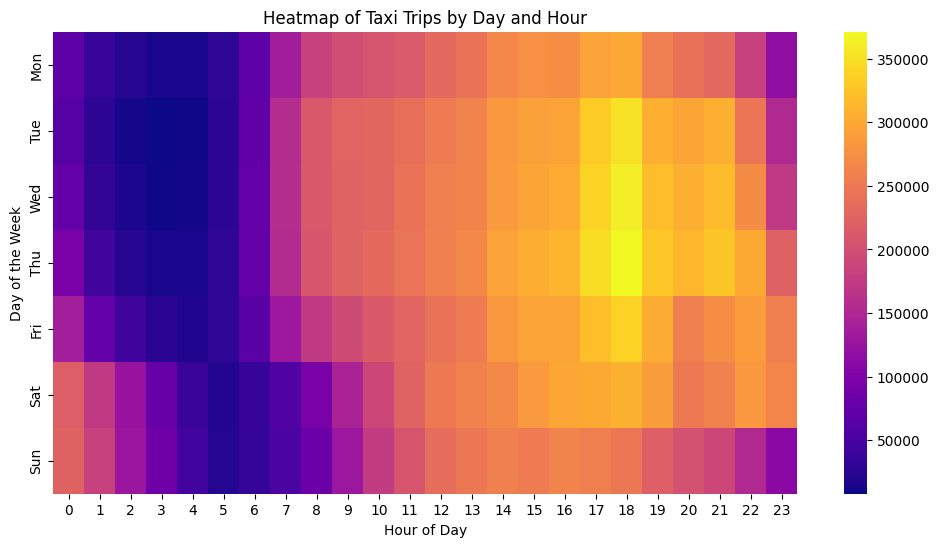

In [ ]:
# Group by hour and day
heatmap_df = df.groupBy("pickup_day", "pickup_hour").count().toPandas()

# Pivot for heatmap
heatmap_pivot = heatmap_df.pivot(index="pickup_day", columns="pickup_hour", values="count")

# Reorder day index
order = ["Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_pivot = heatmap_pivot.reindex(order)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="plasma", annot=False, fmt="g")
plt.title("Heatmap of Taxi Trips by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of the Week")
plt.show()


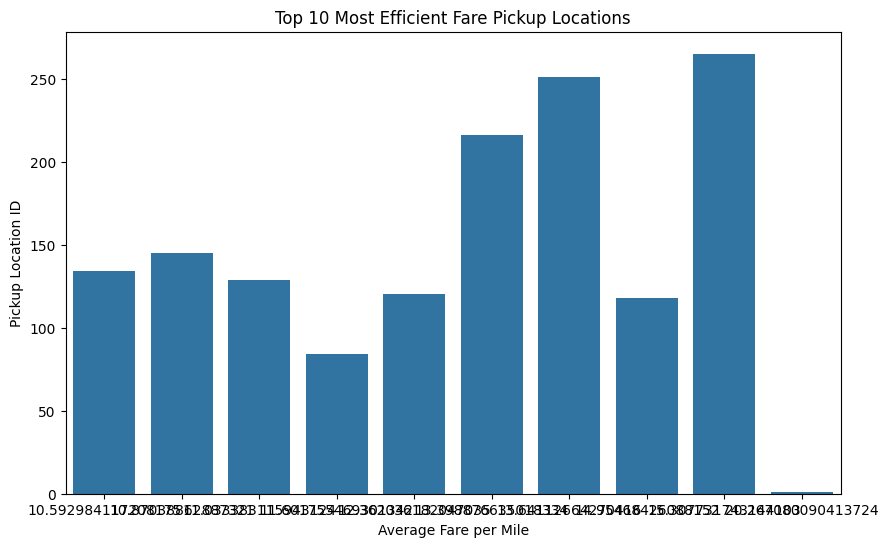

In [ ]:
df = df.withColumn("fare_per_mile", col("fare_amount") / (col("trip_distance") + 0.01))
eff_df = df.groupBy("PULocationID").agg({"fare_per_mile": "avg"}).withColumnRenamed("avg(fare_per_mile)", "avg_fare_per_mile")
eff_pd = eff_df.toPandas().sort_values("avg_fare_per_mile", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="avg_fare_per_mile", y="PULocationID", data=eff_pd)
plt.title("Top 10 Most Efficient Fare Pickup Locations")
plt.xlabel("Average Fare per Mile")
plt.ylabel("Pickup Location ID")
plt.show()


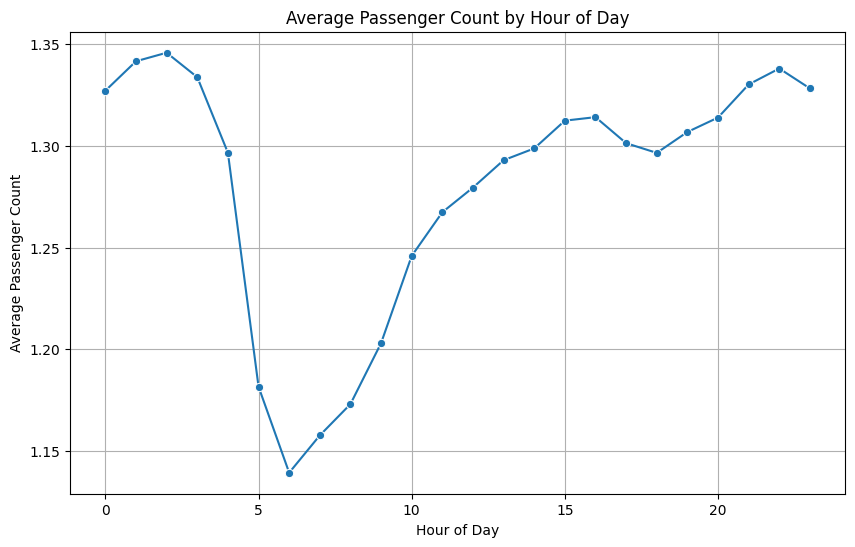

In [ ]:
from pyspark.sql.functions import hour

df = df.withColumn("hour", hour("tpep_pickup_datetime"))
passenger_df = df.groupBy("hour").agg({"passenger_count": "avg"}).withColumnRenamed("avg(passenger_count)", "avg_passenger_count")
passenger_pd = passenger_df.toPandas().sort_values("hour")

plt.figure(figsize=(10, 6))
sns.lineplot(x="hour", y="avg_passenger_count", data=passenger_pd, marker='o')
plt.title("Average Passenger Count by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Passenger Count")
plt.grid(True)
plt.show()


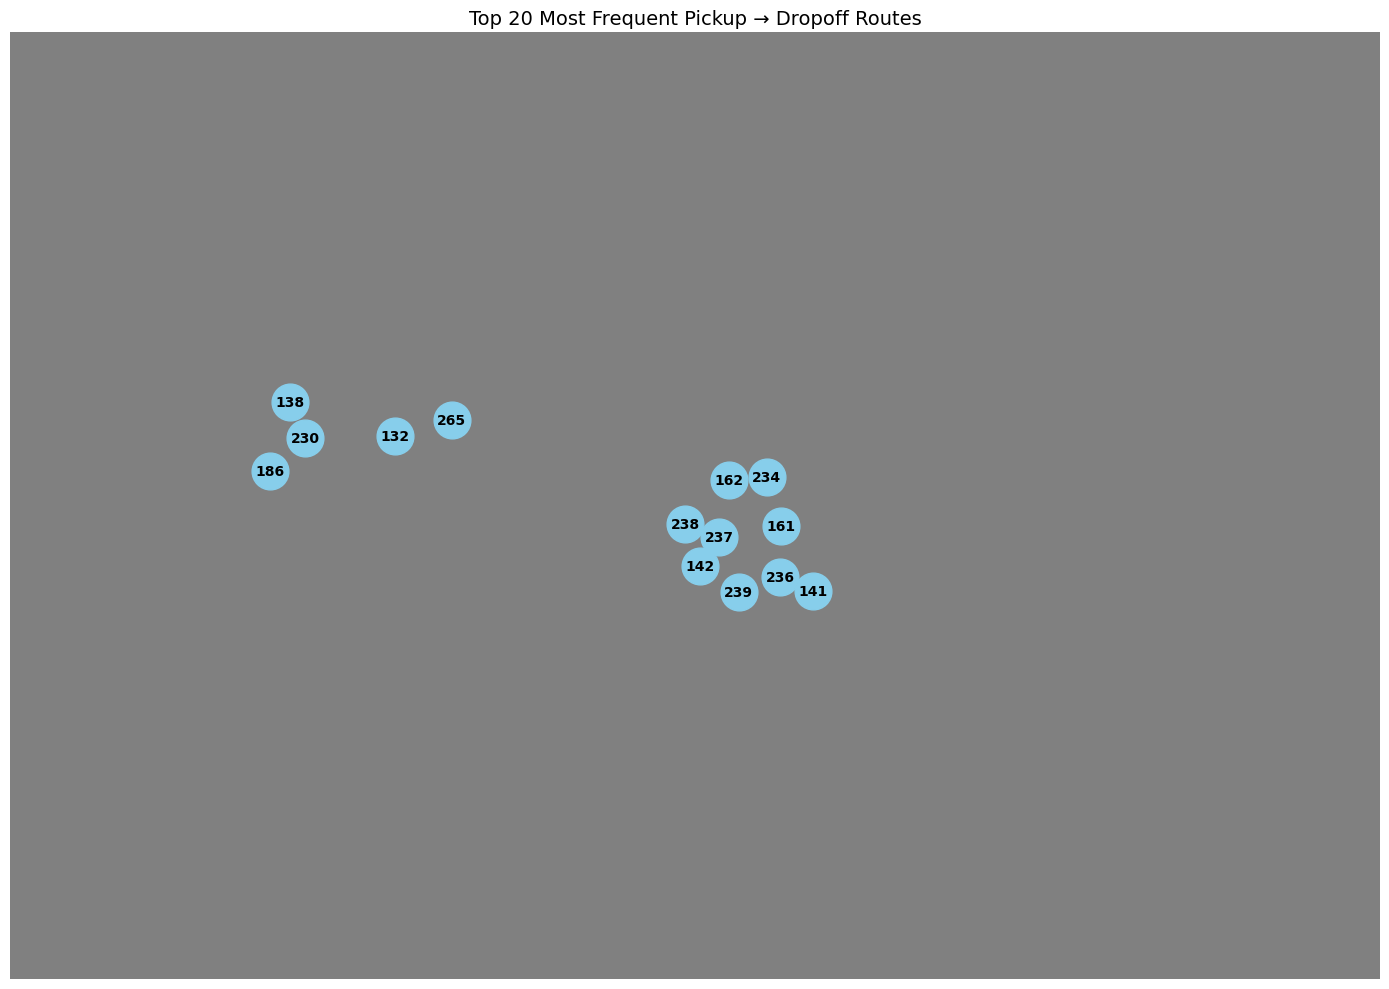

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from pyspark.sql.functions import count, col

# Get top 20 most frequent routes
top_routes = df.groupBy("PULocationID", "DOLocationID").agg(count("*").alias("trip_count"))
top_routes_pd = top_routes.orderBy(col("trip_count").desc()).limit(20).toPandas()

# Create the directed graph
G = nx.DiGraph()
for _, row in top_routes_pd.iterrows():
    G.add_edge(row["PULocationID"], row["DOLocationID"], weight=row["trip_count"])

# Improve layout and sizing
plt.figure(figsize=(14, 10))
pos = nx.kamada_kawai_layout(G)

# Scale edge thickness
weights = [G[u][v]['weight'] / 100 for u, v in G.edges()]

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=weights, arrows=True, arrowstyle='-|>', arrowsize=15)

# Add labels separately
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Turn off axis and add title
plt.axis('off')
plt.title("Top 20 Most Frequent Pickup → Dropoff Routes", fontsize=14)
plt.tight_layout()
plt.show()
